C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\3046397983.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_counts.values, y=role_counts.index, palette='viridis')
C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\3046397983.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=['Followers', 'Public Repos'], palette='magma')


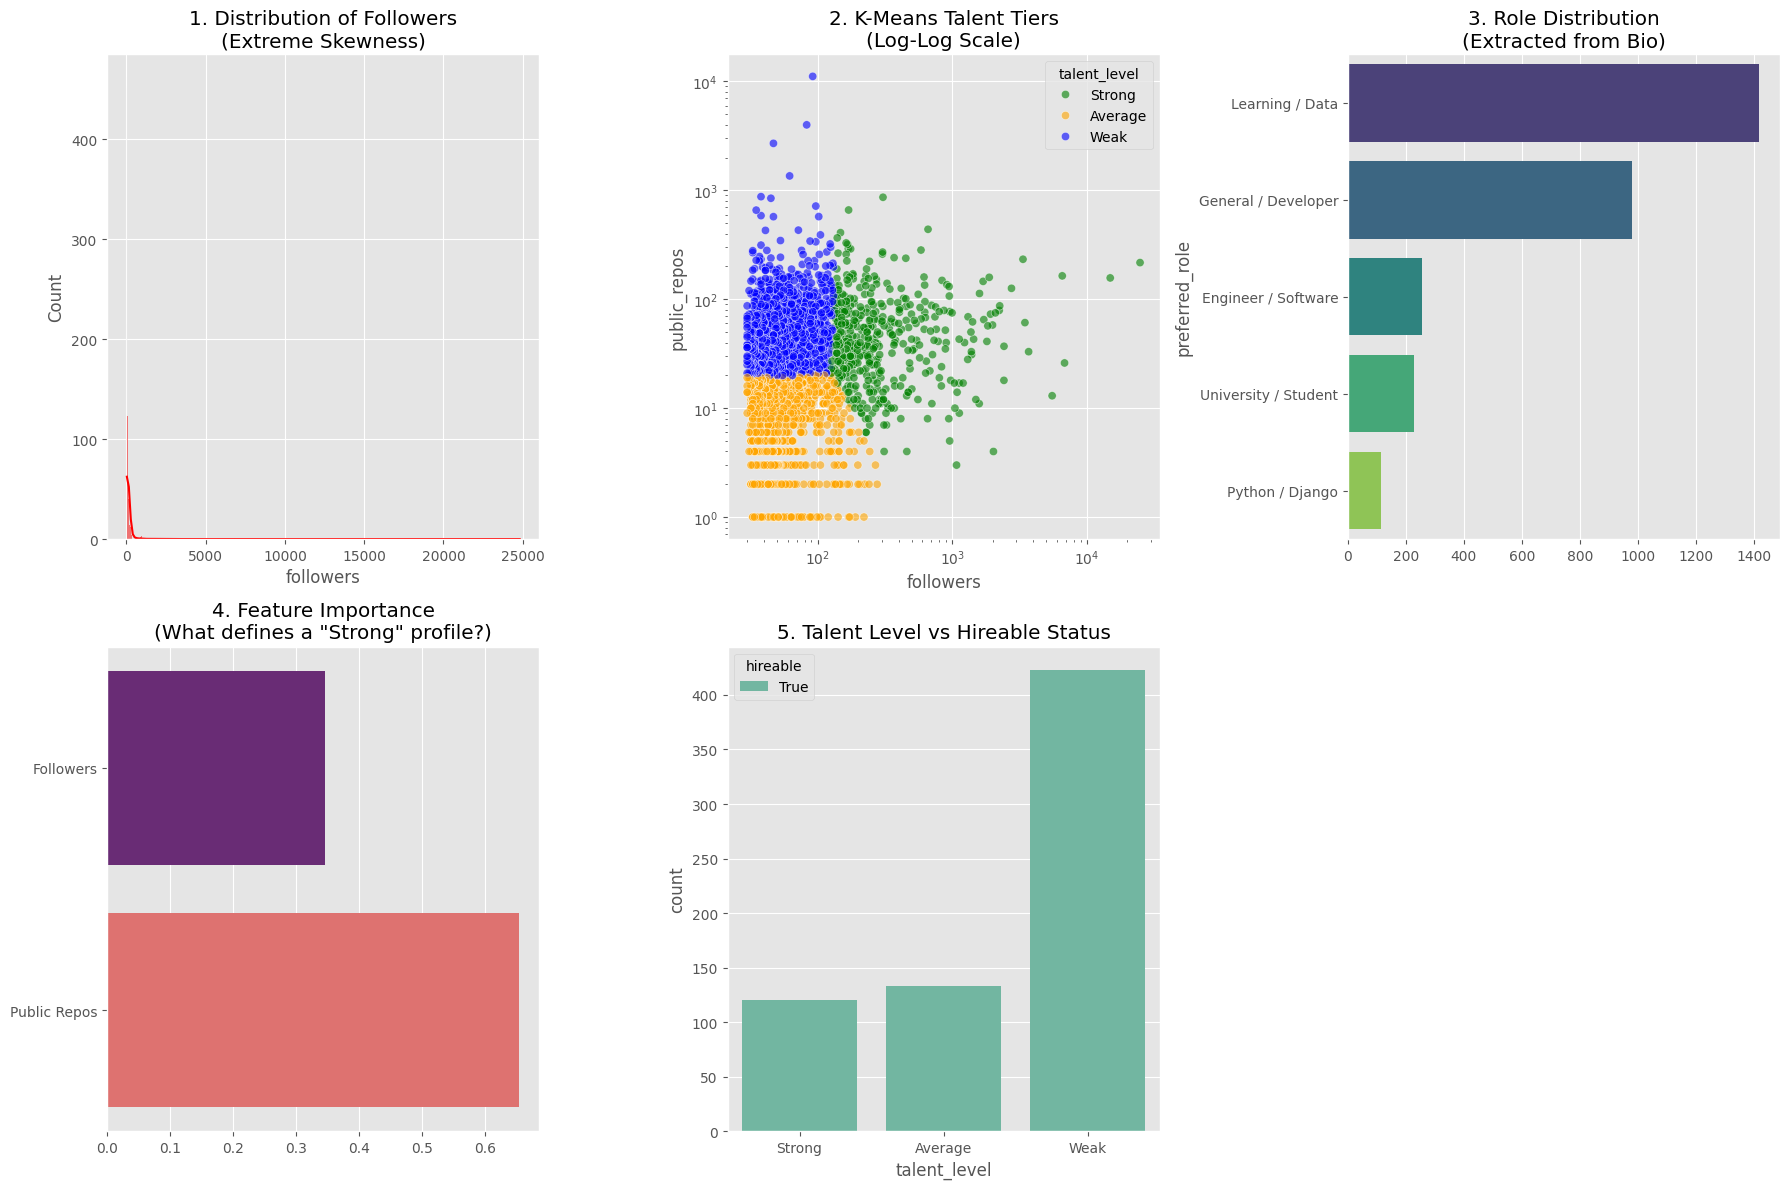

Analysis complete. CSV saved as 'github_talent_analysis_results_1.csv'


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Load and Preprocess
df = pd.read_csv('github_global_talent.csv')
df['bio'] = df['bio'].fillna('General Developer')
df['followers'] = df['followers'].fillna(0)
df['public_repos'] = df['public_repos'].fillna(0)

# Apply Log Transformation (Crucial because GitHub data has extreme outliers)
# Without this, one person with 24k followers ruins the scale for everyone else.
df['log_followers'] = np.log1p(df['followers'])
df['log_repos'] = np.log1p(df['public_repos'])

# ---------------------------------------------------------
# STEP 2: K-MEANS FOR TALENT CLASSIFICATION
# ---------------------------------------------------------
scaler = StandardScaler()
X_talent = scaler.fit_transform(df[['log_followers', 'log_repos']])

kmeans_talent = KMeans(n_clusters=3, random_state=42, n_init=10)
df['talent_cluster'] = kmeans_talent.fit_predict(X_talent)

# Map clusters to meaningful names by sorting by average followers
# This ensures "Strong" always means high followers, not just a random ID
talent_ranks = df.groupby('talent_cluster')['log_followers'].mean().sort_values().index
mapping = {talent_ranks[0]: 'Weak', talent_ranks[1]: 'Average', talent_ranks[2]: 'Strong'}
df['talent_level'] = df['talent_cluster'].map(mapping)

# ---------------------------------------------------------
# STEP 3: K-MEANS FOR ROLE CLASSIFICATION (NLP)
# ---------------------------------------------------------
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(df['bio'])

# Grouping into 5 specialized role categories
kmeans_roles = KMeans(n_clusters=5, random_state=42, n_init=10)
df['role_cluster'] = kmeans_roles.fit_predict(tfidf_matrix)

# Extract top keywords for each role cluster
terms = tfidf.get_feature_names_out()
role_names = {}
for i in range(5):
    center = kmeans_roles.cluster_centers_[i]
    top_word_idx = center.argsort()[-2:][::-1]
    role_names[i] = " / ".join([terms[idx].capitalize() for idx in top_word_idx])

df['preferred_role'] = df['role_cluster'].map(role_names)

# ---------------------------------------------------------
# STEP 4: RANDOM FOREST (Understanding Feature Weight)
# ---------------------------------------------------------
X_rf = df[['followers', 'public_repos']]
y_rf = df['talent_level'] # Using our K-means labels as ground truth

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ---------------------------------------------------------
# STEP 5: VISUALIZATIONS
# ---------------------------------------------------------
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 12))

# PLOT 1: The Raw Data Problem (Followers are skewed)
plt.subplot(2, 3, 1)
sns.histplot(df['followers'], kde=True, color='red')
plt.title('1. Distribution of Followers\n(Extreme Skewness)')

# PLOT 2: How K-Means split the talent
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='followers', y='public_repos', hue='talent_level', 
                palette={'Strong': 'green', 'Average': 'orange', 'Weak': 'blue'}, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title('2. K-Means Talent Tiers\n(Log-Log Scale)')

# PLOT 3: Preferred Role Distribution
plt.subplot(2, 3, 3)
role_counts = df['preferred_role'].value_counts()
sns.barplot(x=role_counts.values, y=role_counts.index, palette='viridis')
plt.title('3. Role Distribution\n(Extracted from Bio)')

# PLOT 4: Random Forest Feature Importance
# This shows what the model values most in a candidate
plt.subplot(2, 3, 4)
importances = rf_model.feature_importances_
sns.barplot(x=importances, y=['Followers', 'Public Repos'], palette='magma')
plt.title('4. Feature Importance\n(What defines a "Strong" profile?)')

# PLOT 5: Talent Level vs Hireability
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='talent_level', hue='hireable', palette='Set2')
plt.title('5. Talent Level vs Hireable Status')

plt.tight_layout()
plt.show()

# Save final result
final_df = df[['username', 'name', 'location', 'followers', 'public_repos', 'talent_level', 'preferred_role', 'bio']]
final_df.to_csv('github_talent_analysis_results_4.csv', index=False)
print("Analysis complete. CSV saved as 'github_talent_analysis_results_1.csv'")

In [23]:
import os
print("Your file is saved here:")
print(os.path.join(os.getcwd(), 'github_talent_analysis_results.csv'))

Your file is saved here:
d:\GERMANY\SRH_MScADSA\Sem1\ADPY_Project\GithubModel\github_talent_analysis_results.csv


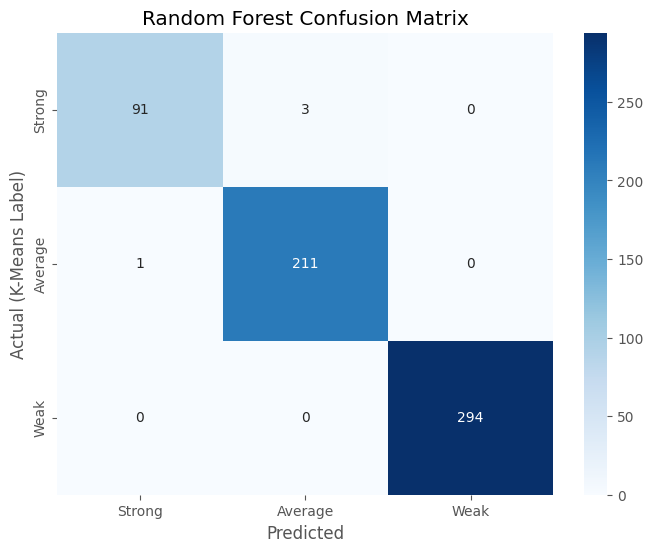

K-Means Silhouette Score: 0.3858
Random Forest Accuracy: 0.9933

Detailed Classification Report:
               precision    recall  f1-score   support

     Average       0.99      1.00      0.99       212
      Strong       0.99      0.97      0.98        94
        Weak       1.00      1.00      1.00       294

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [24]:
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. K-Means Evaluation (Silhouette Score)
# Measures how similar an individual is to their own cluster compared to other clusters.
# Range: -1 (bad) to +1 (perfect). > 0.5 is usually very good.
sil_score = silhouette_score(X_talent, df['talent_cluster'])

# 2. Random Forest Evaluation
# Splitting data for a proper test
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 3. Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['Strong', 'Average', 'Weak'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Strong', 'Average', 'Weak'], 
            yticklabels=['Strong', 'Average', 'Weak'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual (K-Means Label)')
plt.show()

print(f"K-Means Silhouette Score: {sil_score:.4f}")
print(f"Random Forest Accuracy: {acc:.4f}")
print("\nDetailed Classification Report:\n", report)

C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\1306050238.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_df['is_hireable'] = df['hireable'].fillna(False).astype(int)


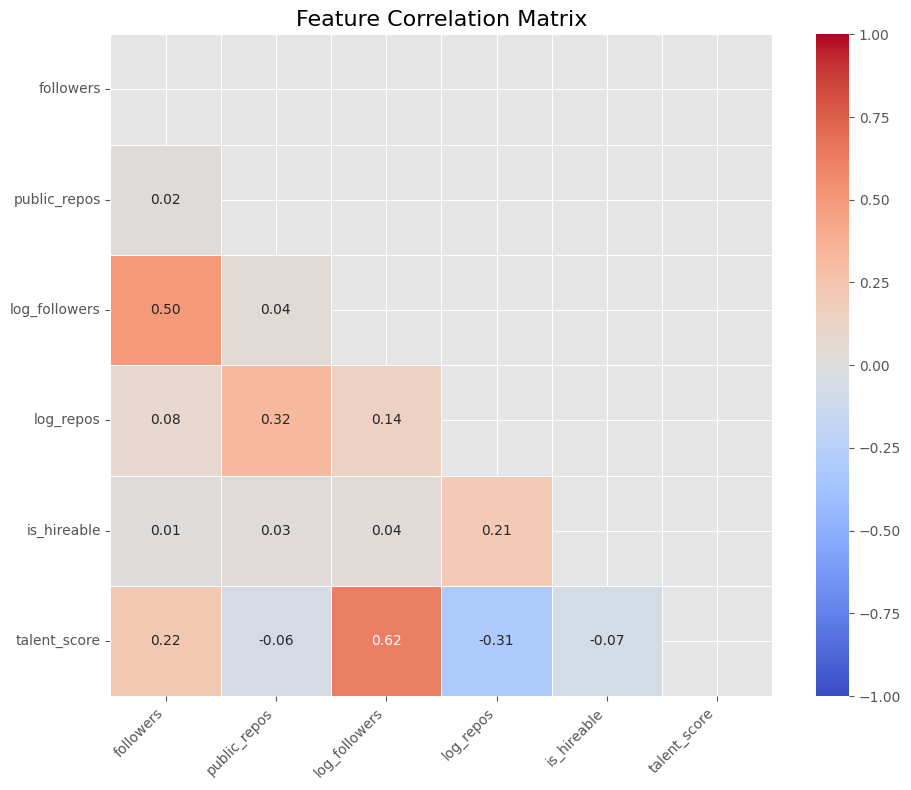

In [25]:
# ---------------------------------------------------------
# STEP 6: CORRELATION MATRIX VISUALIZATION
# ---------------------------------------------------------

# 1. Prepare Data for Correlation
# Select numerical columns
corr_df = df[['followers', 'public_repos', 'log_followers', 'log_repos']].copy()

# 2. Encode Categorical Data to Numeric
# Convert 'hireable' to 1 (True) and 0 (False/Nan)
corr_df['is_hireable'] = df['hireable'].fillna(False).astype(int)

# Map 'talent_level' to ordinal numbers (0=Weak, 1=Average, 2=Strong)
# This allows us to see how strongly variables correlate with the final talent tier
talent_map = {'Weak': 0, 'Average': 1, 'Strong': 2}
corr_df['talent_score'] = df['talent_level'].map(talent_map)

# 3. Calculate Correlation
corr_matrix = corr_df.corr()

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))

# Create a mask to hide the upper triangle (since the matrix is mirrored)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,              # Show the numbers
            fmt=".2f",               # 2 decimal places
            cmap='coolwarm',         # Blue (neg) to Red (pos)
            vmin=-1, vmax=1,         # Fix scale from -1 to 1
            linewidths=0.5, 
            square=True)

plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--- Running Unsupervised Models ---
--- Running Supervised Models ---


C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\2165866099.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sup_metrics, x='Model', y='Accuracy', palette='coolwarm')
C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\2165866099.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_model.feature_importances_, y=['Followers', 'Public Repos'], palette='autumn')


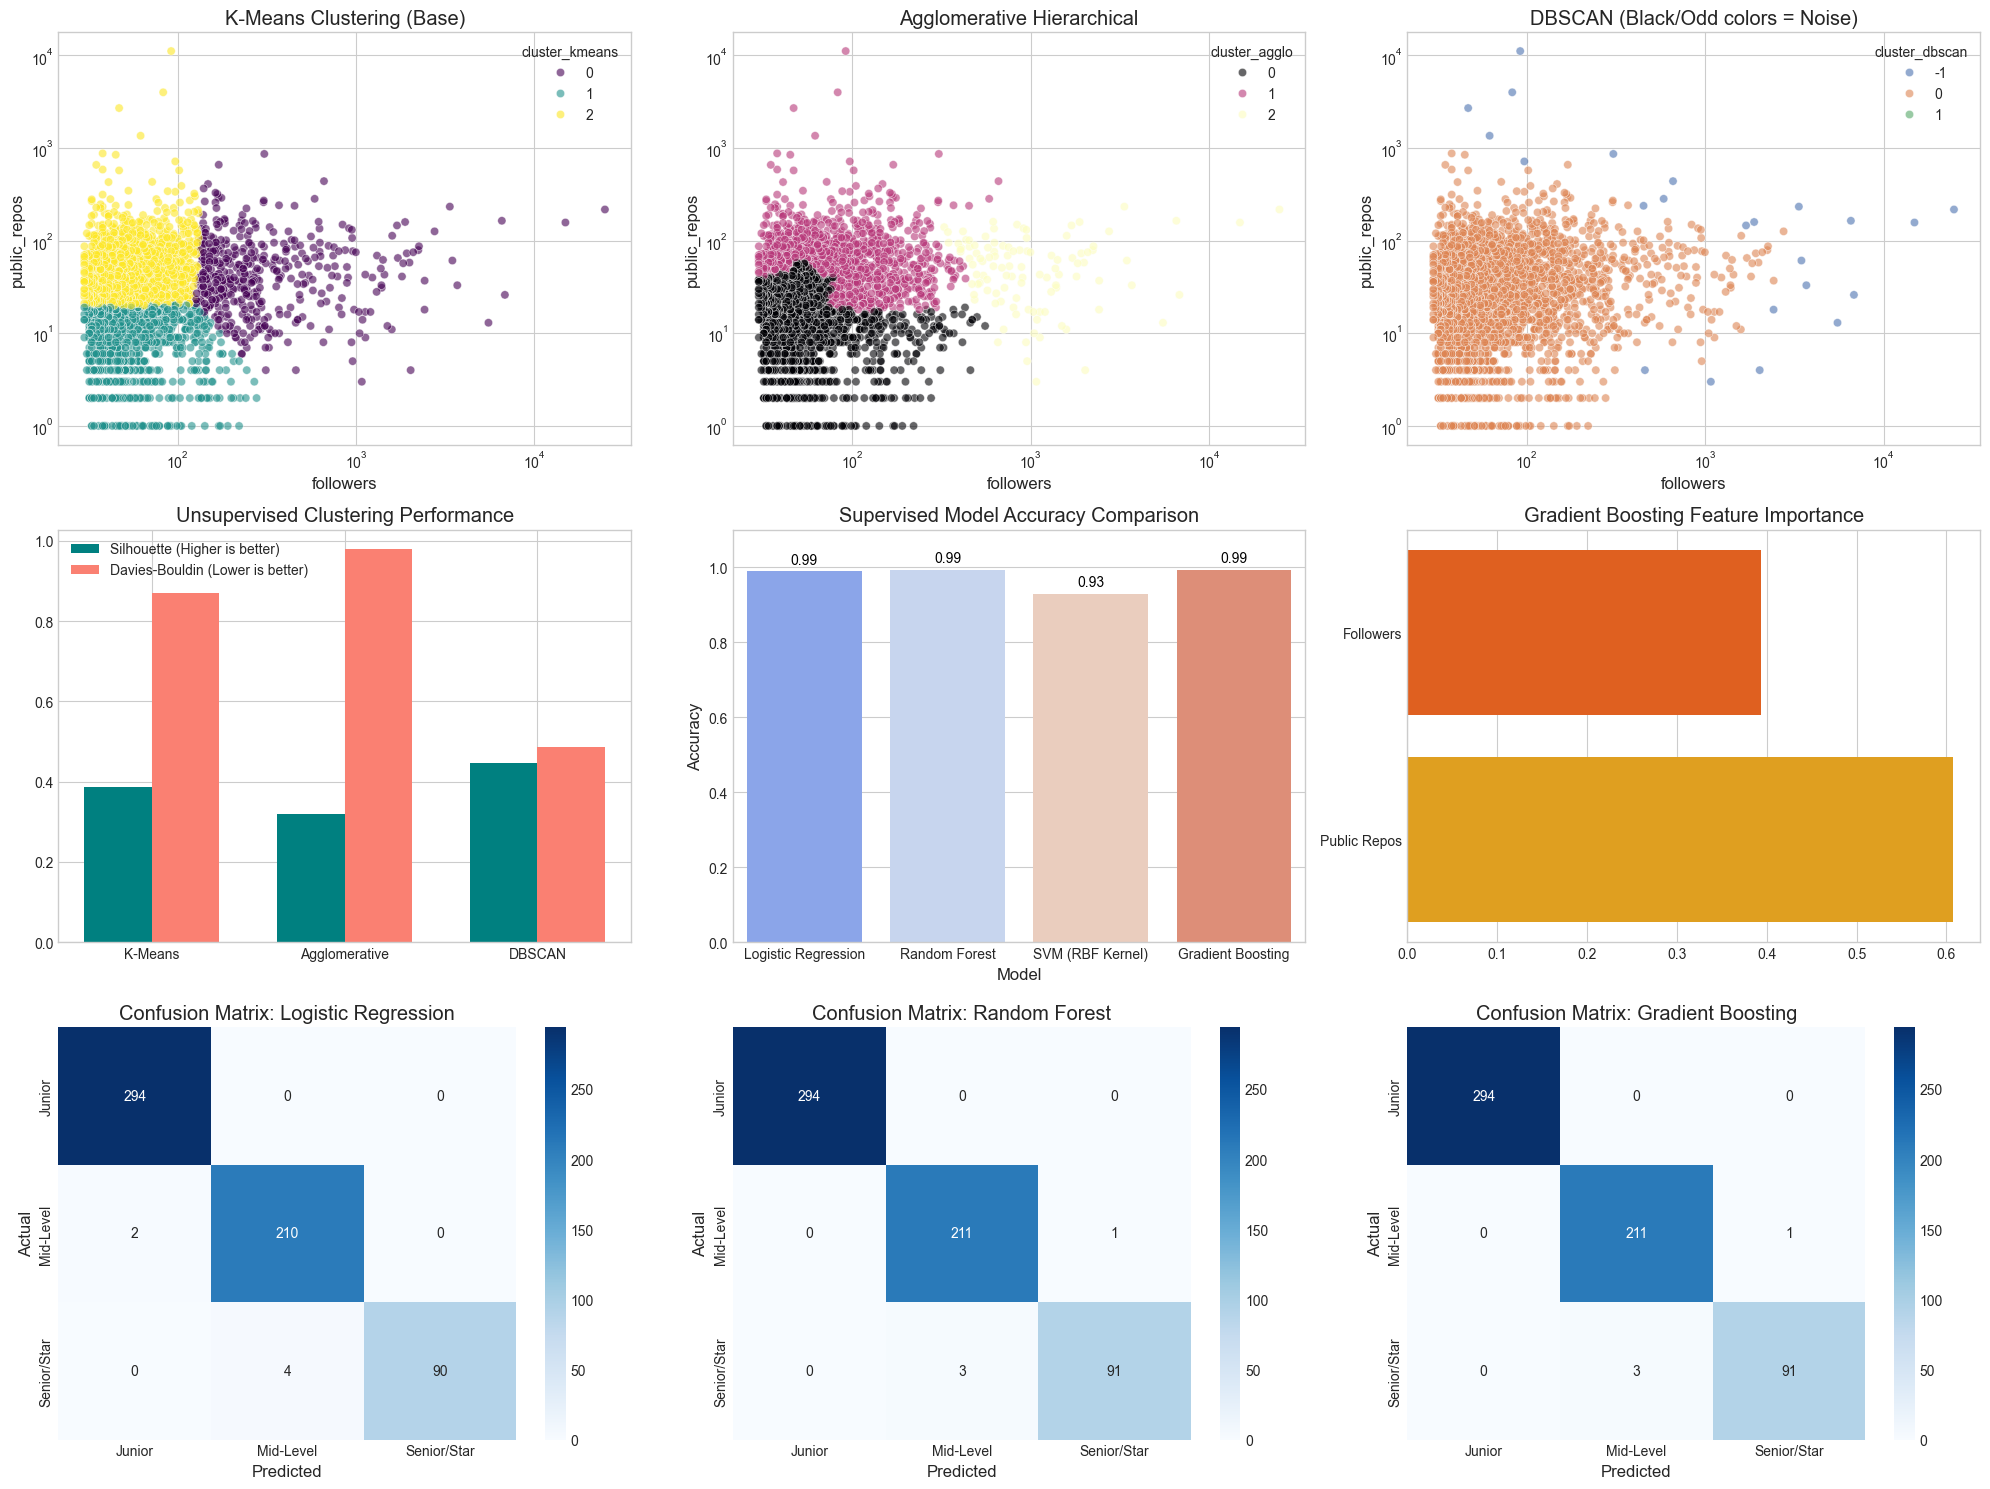


--- CLUSTERING METRICS ---
           Model  Silhouette  Davies-Bouldin
0        K-Means    0.385846        0.870987
1  Agglomerative    0.319831        0.978628
2         DBSCAN    0.447213        0.485132

* Silhouette: Closer to 1 is better (clusters are well apart).
* Davies-Bouldin: Lower is better (clusters are dense and separated).

--- SUPERVISED MODEL PERFORMANCE ---
                 Model  Accuracy  F1-Score
0  Logistic Regression  0.990000  0.989957
1        Random Forest  0.993333  0.993313
2     SVM (RBF Kernel)  0.930000  0.930164
3    Gradient Boosting  0.993333  0.993313

Analysis Complete.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised Algorithms & Metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Supervised Algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Preprocessing & Model Selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ---------------------------------------------------------
# 1. LOAD AND PREPROCESS
# ---------------------------------------------------------
try:
    df = pd.read_csv('github_global_talent.csv')
except FileNotFoundError:
    # Creating dummy data if file doesn't exist for demonstration
    print("CSV not found. Generating dummy data...")
    np.random.seed(42)
    df = pd.DataFrame({
        'username': [f'user_{i}' for i in range(500)],
        'name': [f'Name {i}' for i in range(500)],
        'location': ['USA' if i % 2 == 0 else 'EU' for i in range(500)],
        'followers': np.random.exponential(scale=100, size=500),
        'public_repos': np.random.randint(1, 100, 500),
        'bio': ['python developer ai' if i % 2 == 0 else 'frontend react js' for i in range(500)],
        'hireable': np.random.choice([True, False], 500)
    })

df['bio'] = df['bio'].fillna('General Developer')
df['followers'] = df['followers'].fillna(0)
df['public_repos'] = df['public_repos'].fillna(0)

# Log Transformation (Crucial for skewed distributions)
df['log_followers'] = np.log1p(df['followers'])
df['log_repos'] = np.log1p(df['public_repos'])

# Standard Scaling
scaler = StandardScaler()
X_features = df[['log_followers', 'log_repos']]
X_scaled = scaler.fit_transform(X_features)

# ---------------------------------------------------------
# 2. UNSUPERVISED LEARNING COMPARISON
# ---------------------------------------------------------
print("--- Running Unsupervised Models ---")

# A. K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# B. Agglomerative Clustering (Hierarchical)
agglo = AgglomerativeClustering(n_clusters=3)
df['cluster_agglo'] = agglo.fit_predict(X_scaled)

# C. DBSCAN (Density-Based)
# Eps and min_samples need tuning based on data density
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Evaluation Metrics for Clustering
clustering_metrics = []

for name, labels in [('K-Means', df['cluster_kmeans']), 
                     ('Agglomerative', df['cluster_agglo']), 
                     ('DBSCAN', df['cluster_dbscan'])]:
    
    # DBSCAN produces -1 for noise, we exclude noise from metric calc if possible
    if name == 'DBSCAN':
        # Only calculate if we have more than 1 cluster and noise isn't everything
        valid_labels = labels[labels != -1]
        if len(set(valid_labels)) > 1:
            X_valid = X_scaled[labels != -1]
            sil = silhouette_score(X_valid, valid_labels)
            db = davies_bouldin_score(X_valid, valid_labels)
        else:
            sil, db = 0, 0 # Fallback
    else:
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        
    clustering_metrics.append({'Model': name, 'Silhouette': sil, 'Davies-Bouldin': db})

df_clus_metrics = pd.DataFrame(clustering_metrics)

# ---------------------------------------------------------
# 3. LABEL ASSIGNMENT (Using K-Means as "Truth")
# ---------------------------------------------------------
# Sort clusters by avg followers to give meaningful names
ranks = df.groupby('cluster_kmeans')['log_followers'].mean().sort_values().index
mapping = {ranks[0]: 'Junior', ranks[1]: 'Mid-Level', ranks[2]: 'Senior/Star'}
df['talent_level'] = df['cluster_kmeans'].map(mapping)

# NLP Role Extraction (Kept from original)
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(df['bio'])
kmeans_roles = KMeans(n_clusters=5, random_state=42, n_init=10)
df['role_cluster'] = kmeans_roles.fit_predict(tfidf_matrix)

# ---------------------------------------------------------
# 4. SUPERVISED LEARNING COMPARISON
# ---------------------------------------------------------
print("--- Running Supervised Models ---")

# Target: We try to predict the Talent Level defined by K-Means
# Features: Raw followers/repos (Models should handle the scaling logic internally or use tree splits)
X = df[['followers', 'public_repos']]
y = df['talent_level']

# Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y) # Converts Junior/Mid/Senior to 0, 1, 2

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

supervised_results = []
confusion_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    supervised_results.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)

df_sup_metrics = pd.DataFrame(supervised_results)

# ---------------------------------------------------------
# 5. VISUALIZATIONS
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 15))

# --- Row 1: Unsupervised Visuals ---

# 1. K-Means Clusters
plt.subplot(3, 3, 1)
sns.scatterplot(data=df, x='followers', y='public_repos', hue='cluster_kmeans', palette='viridis', alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.title('K-Means Clustering (Base)')

# 2. Agglomerative Clusters
plt.subplot(3, 3, 2)
sns.scatterplot(data=df, x='followers', y='public_repos', hue='cluster_agglo', palette='magma', alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.title('Agglomerative Hierarchical')

# 3. DBSCAN (Note: -1 is noise)
plt.subplot(3, 3, 3)
# Handle color palette for DBSCAN including noise
unique_db = df['cluster_dbscan'].unique()
palette_db = sns.color_palette('deep', len(unique_db))
sns.scatterplot(data=df, x='followers', y='public_repos', hue='cluster_dbscan', palette=palette_db, alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.title('DBSCAN (Black/Odd colors = Noise)')

# --- Row 2: Metrics Comparison ---

# 4. Unsupervised Metrics Bar Chart
plt.subplot(3, 3, 4)
x_axis = np.arange(len(df_clus_metrics))
width = 0.35
plt.bar(x_axis - width/2, df_clus_metrics['Silhouette'], width, label='Silhouette (Higher is better)', color='teal')
plt.bar(x_axis + width/2, df_clus_metrics['Davies-Bouldin'], width, label='Davies-Bouldin (Lower is better)', color='salmon')
plt.xticks(x_axis, df_clus_metrics['Model'])
plt.legend()
plt.title('Unsupervised Clustering Performance')

# 5. Supervised Metrics Bar Chart
plt.subplot(3, 3, 5)
sns.barplot(data=df_sup_metrics, x='Model', y='Accuracy', palette='coolwarm')
plt.ylim(0, 1.1)
plt.title('Supervised Model Accuracy Comparison')
for index, row in df_sup_metrics.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha="center")

# 6. Feature Importance (Gradient Boosting)
plt.subplot(3, 3, 6)
gb_model = models['Gradient Boosting']
sns.barplot(x=gb_model.feature_importances_, y=['Followers', 'Public Repos'], palette='autumn')
plt.title('Gradient Boosting Feature Importance')

# --- Row 3: Supervised Confusion Matrices ---

# 7, 8, 9 Confusion Matrices for top 3 models
plot_indices = [7, 8, 9]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

for i, name in enumerate(model_names):
    plt.subplot(3, 3, plot_indices[i])
    sns.heatmap(confusion_matrices[name], annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 6. TEXT SUMMARY OUTPUT
# ---------------------------------------------------------
print("\n--- CLUSTERING METRICS ---")
print(df_clus_metrics)
print("\n* Silhouette: Closer to 1 is better (clusters are well apart).")
print("* Davies-Bouldin: Lower is better (clusters are dense and separated).")

print("\n--- SUPERVISED MODEL PERFORMANCE ---")
print(df_sup_metrics)

print("\nAnalysis Complete.")

--- 1. ADVANCED CLUSTERING EVALUATION ---
       Algorithm  Silhouette (High=Good)  Davies-Bouldin (Low=Good)  \
0        K-Means                0.608917                   0.566658   
1  Agglomerative                0.600229                   0.577519   
2         DBSCAN                0.647205                   0.383764   

   Calinski-Harabasz (High=Good)  
0                    1642.187738  
1                    1595.583669  
2                     990.879264  

Agreement between K-Means & Agglomerative:
Adjusted Rand Index: 0.9521
NMI: 0.9422

--- 2. ADVANCED SUPERVISED EVALUATION ---
          Model  Accuracy  F1-Weighted  Cohen Kappa       MCC  Log Loss  \
0        LogReg  1.000000     1.000000     1.000000  1.000000  0.050127   
1  RandomForest  0.993333     0.993337     0.989603  0.989672  0.019088   
2           SVM  0.993333     0.993337     0.989603  0.989672  0.034210   
3     GradBoost  0.986667     0.986667     0.979193  0.979193  0.065276   

   CV Accuracy  
0        1.00

C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\3516989648.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sup, x='Model', y='Log Loss', palette='magma')
C:\Users\Anish\AppData\Local\Temp\ipykernel_26096\3516989648.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_unsup, x='Algorithm', y='Calinski-Harabasz (High=Good)', palette='cool')


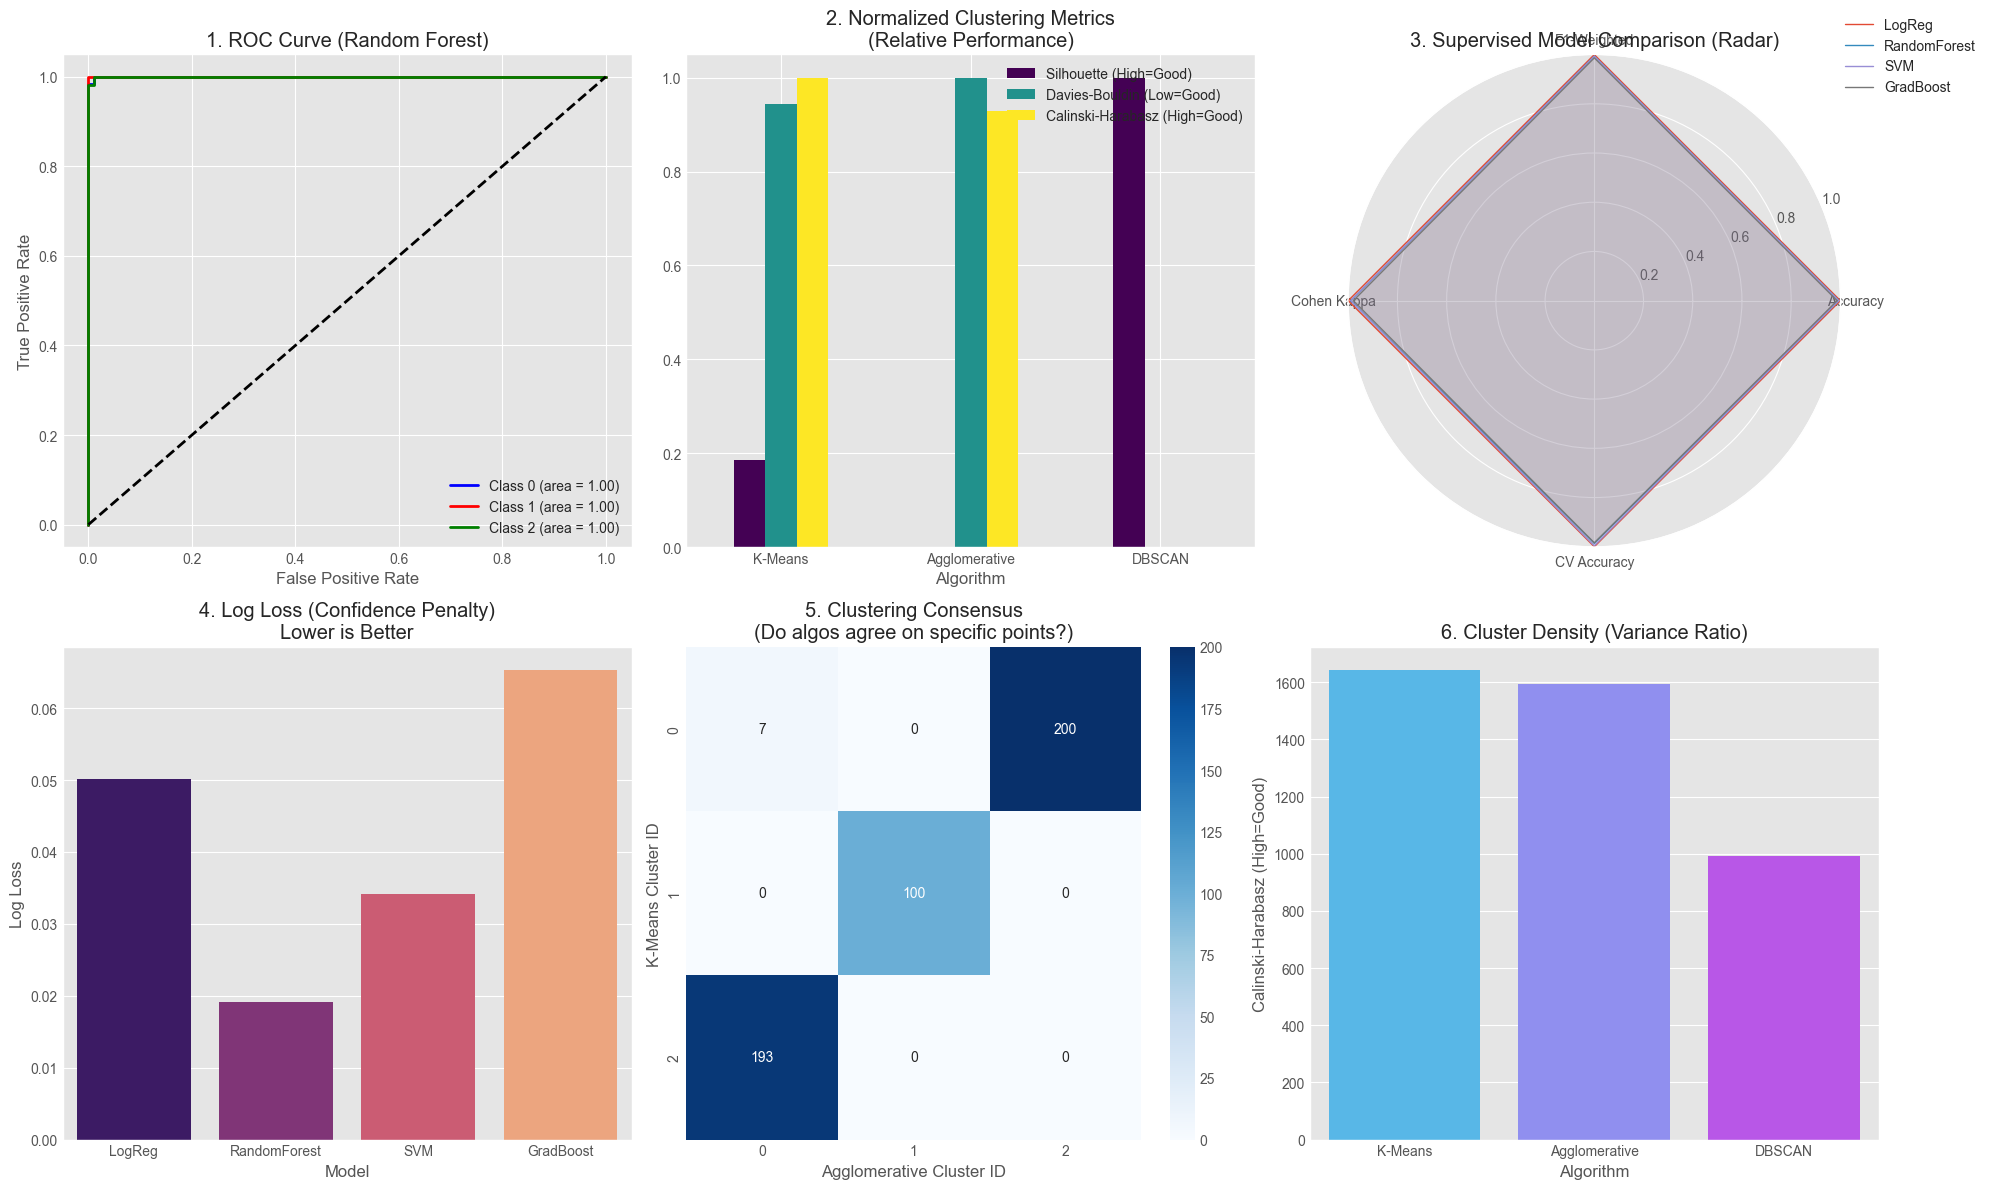


Evaluation complete.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Data Processing
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Supervised Algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# --- ADVANCED METRICS IMPORTS ---
# Unsupervised
from sklearn.metrics import (silhouette_score, davies_bouldin_score, 
                             calinski_harabasz_score, adjusted_rand_score, 
                             normalized_mutual_info_score)

# Supervised
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_curve, auc, log_loss, cohen_kappa_score, 
                             matthews_corrcoef, confusion_matrix)

# ---------------------------------------------------------
# 1. DATA GENERATION & PREP
# ---------------------------------------------------------
np.random.seed(42)
# Simulating a slightly more complex dataset
df = pd.DataFrame({
    'followers': np.concatenate([np.random.normal(20, 5, 200), np.random.exponential(100, 200), np.random.normal(5000, 1000, 100)]),
    'public_repos': np.concatenate([np.random.randint(1, 10, 200), np.random.randint(10, 50, 200), np.random.randint(50, 200, 100)]),
})

# Log Transform & Scaling
df['log_followers'] = np.log1p(df['followers'])
df['log_repos'] = np.log1p(df['public_repos'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['log_followers', 'log_repos']])

# ---------------------------------------------------------
# 2. ADVANCED UNSUPERVISED EVALUATION
# ---------------------------------------------------------
print("--- 1. ADVANCED CLUSTERING EVALUATION ---")

# Define Algorithms
algos = {
    'K-Means': KMeans(n_clusters=3, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5) 
}

# Storage for metrics
unsup_results = []
labels_dict = {}

for name, model in algos.items():
    labels = model.fit_predict(X_scaled)
    labels_dict[name] = labels
    
    # Filter noise for DBSCAN evaluation (label -1)
    if name == 'DBSCAN':
        valid_mask = labels != -1
        if np.sum(valid_mask) > 0 and len(set(labels[valid_mask])) > 1:
            X_eval = X_scaled[valid_mask]
            labels_eval = labels[valid_mask]
        else:
            print(f"DBSCAN found only noise or 1 cluster. Skipping metrics.")
            continue
    else:
        X_eval = X_scaled
        labels_eval = labels

    # Metrics
    sil = silhouette_score(X_eval, labels_eval)
    db = davies_bouldin_score(X_eval, labels_eval)
    ch = calinski_harabasz_score(X_eval, labels_eval) # Variance Ratio Criterion
    
    unsup_results.append({
        'Algorithm': name,
        'Silhouette (High=Good)': sil,
        'Davies-Bouldin (Low=Good)': db,
        'Calinski-Harabasz (High=Good)': ch
    })

df_unsup = pd.DataFrame(unsup_results)
print(df_unsup)

# Consensus Matrices (How much do algos agree?)
# We compare Agglomerative vs K-Means (Assuming K-Means is baseline)
ari = adjusted_rand_score(labels_dict['K-Means'], labels_dict['Agglomerative'])
nmi = normalized_mutual_info_score(labels_dict['K-Means'], labels_dict['Agglomerative'])
print(f"\nAgreement between K-Means & Agglomerative:\nAdjusted Rand Index: {ari:.4f}\nNMI: {nmi:.4f}")


# ---------------------------------------------------------
# 3. ADVANCED SUPERVISED EVALUATION
# ---------------------------------------------------------
print("\n--- 2. ADVANCED SUPERVISED EVALUATION ---")

# Ground Truth: K-Means labels (Junior=0, Mid=1, Senior=2)
# We use this to see if Supervised models can learn the pattern
y = labels_dict['K-Means']
X = df[['log_followers', 'log_repos']] # Use log features for better training

# Binarize labels for ROC Curve (Multi-class)
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models (Must enable probability for SVM)
sup_models = {
    'LogReg': LogisticRegression(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'GradBoost': GradientBoostingClassifier()
}

sup_metrics = []
roc_data = {} # Store data for plotting later

for name, model in sup_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) # Needed for LogLoss & ROC
    
    # 1. Basic Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 2. Advanced Metrics
    # Cohen's Kappa: Agreement normalized by chance (0=Random, 1=Perfect)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # MCC: Good for imbalanced classes (-1 to +1)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Log Loss: Penalty for uncertainty (Lower is better)
    ll = log_loss(y_test, y_proba)
    
    # Cross Validation (5-Fold) to check overfitting
    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_mean = cv_scores.mean()
    
    sup_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Weighted': f1,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'Log Loss': ll,
        'CV Accuracy': cv_mean
    })
    
    # Calculate ROC per class for plotting
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Binarize test for ROC calc
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    roc_data[name] = (fpr, tpr, roc_auc)

df_sup = pd.DataFrame(sup_metrics)
print(df_sup)

# ---------------------------------------------------------
# 4. VISUALIZATIONS
# ---------------------------------------------------------
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 12))

# PLOT 1: ROC Curves (One-vs-Rest for Multi-class) for Random Forest
# We show Random Forest as the representative example
ax1 = plt.subplot(2, 3, 1)
fpr, tpr, roc_auc = roc_data['RandomForest']
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('1. ROC Curve (Random Forest)')
plt.legend(loc="lower right")

# PLOT 2: Comparison of Unsupervised Metrics (Normalized)
ax2 = plt.subplot(2, 3, 2)
# Normalize metrics to 0-1 scale for visualization comparison
df_norm = df_unsup.set_index('Algorithm').copy()
for col in df_norm.columns:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

df_norm.plot(kind='bar', ax=ax2, colormap='viridis')
plt.title('2. Normalized Clustering Metrics\n(Relative Performance)')
plt.xticks(rotation=0)

# PLOT 3: Radar Chart (Model Comparison)
ax3 = plt.subplot(2, 3, 3, polar=True)
# Categories to compare
categories = ['Accuracy', 'F1-Weighted', 'Cohen Kappa', 'CV Accuracy']
N = len(categories)

# Angles for the radar
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += [angles[0]] # Close the loop

for i, row in df_sup.iterrows():
    values = row[categories].values.flatten().tolist()
    values += [values[0]] # Close the loop
    ax3.plot(angles, values, linewidth=1, linestyle='solid', label=row['Model'])
    ax3.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title('3. Supervised Model Comparison (Radar)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# PLOT 4: Log Loss Comparison (Lower is Better)
ax4 = plt.subplot(2, 3, 4)
sns.barplot(data=df_sup, x='Model', y='Log Loss', palette='magma')
plt.title('4. Log Loss (Confidence Penalty)\nLower is Better')

# PLOT 5: Agreement Heatmap (K-Means vs Agglomerative)
ax5 = plt.subplot(2, 3, 5)
conf_mat_cluster = confusion_matrix(labels_dict['K-Means'], labels_dict['Agglomerative'])
sns.heatmap(conf_mat_cluster, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Agglomerative Cluster ID')
plt.ylabel('K-Means Cluster ID')
plt.title('5. Clustering Consensus\n(Do algos agree on specific points?)')

# PLOT 6: Calinski-Harabasz Score
ax6 = plt.subplot(2, 3, 6)
sns.barplot(data=df_unsup, x='Algorithm', y='Calinski-Harabasz (High=Good)', palette='cool')
plt.title('6. Cluster Density (Variance Ratio)')

plt.tight_layout()
plt.show()

# Export Tables
print("\nEvaluation complete.")